In [1]:
%load_ext autoreload
%autoreload 2
# Enable imports form top-level of project (edit top_level_path accordingly)
import os
import sys
import inspect
from utils import *

top_level_path = os.path.abspath(os.path.join('..'))
if top_level_path not in sys.path:
	sys.path.append(top_level_path)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from longestpath.gen import gen_num_edges_undirected
from benchmarking import new_benchmark, Solver

## Benchmarking

Creates a new benchmark:

In [2]:
def generate():
  return [
    gen_num_edges_undirected(15, round(15 * degree / 2))
      for degree in np.arange(1.2, 3.7,0.2) for _ in range(1)
  ]

params_code = inspect.getsource(generate)
graphs = generate()

benchmark = new_benchmark(graphs, solvers=[
	Solver("brute", "FAST_BOUND"),
	Solver("brute", "BRUTE_FORCE"),
	Solver("brute", "BRANCH_N_BOUND"),
	Solver("brute", "BRUTE_FORCE_COMPLETE"),
  Solver("ilp"),
	Solver("kalp", threads=4),
	Solver("kalp"),
], params_code = params_code, override_benchmark_path="../benchmarks/test")

benchmark.benchmark_path


'../benchmarks/test(11)'

Loads an existing benchmark

In [2]:
benchmark = Benchmark.load("../final_benchmarks/all_methods_1.2-3.6_50_runs/")

Runs `benchmark`

In [3]:
benchmark.run(retryFailures=True, timeout=5)


graph: 0.txt, solver: brute('FAST_BOUND') ... ✅
length: 6, run_time: 7e-06
graph: 1.txt, solver: brute('FAST_BOUND') ... ✅
length: 6, run_time: 6e-06
graph: 2.txt, solver: brute('FAST_BOUND') ... ✅
length: 7, run_time: 6e-06
graph: 3.txt, solver: brute('FAST_BOUND') ... ✅
length: 8, run_time: 8e-06
graph: 4.txt, solver: brute('FAST_BOUND') ... ✅
length: 8, run_time: 9e-06
graph: 5.txt, solver: brute('FAST_BOUND') ... ✅
length: 10, run_time: 1.8e-05
graph: 6.txt, solver: brute('FAST_BOUND') ... ✅
length: 11, run_time: 2.9e-05
graph: 7.txt, solver: brute('FAST_BOUND') ... ✅
length: 12, run_time: 5.7e-05
graph: 8.txt, solver: brute('FAST_BOUND') ... ✅
length: 13, run_time: 0.000158
graph: 9.txt, solver: brute('FAST_BOUND') ... ✅
length: 13, run_time: 0.000262
graph: 10.txt, solver: brute('FAST_BOUND') ... ✅
length: 13, run_time: 0.000104
graph: 11.txt, solver: brute('FAST_BOUND') ... ✅
length: 13, run_time: 0.000563
graph: 12.txt, solver: brute('FAST_BOUND') ... ✅
length: 13, run_time: 0.

## Data processing

We collect the data relating to `benchmark` into a single dataframe

In [3]:
df = benchmark.get_dataframe()
df.head()

,path,run_time,length,solver,graph_id,status,objective_value,failure,solver_name,vertices,edges,average_out_degree
0,"[6, 28, 2, 7, 26, 21, 3, 19]",0.000006,7.0,0,0,NaN,NaN,NaN,brute('FAST_BOUND'),30,36,1.2
1,"[4, 17, 8, 19, 7, 5, 26, 1, 11, 14, 10]",0.000010,10.0,0,1,NaN,NaN,NaN,brute('FAST_BOUND'),30,36,1.2
2,"[4, 15, 25, 20, 14, 29]",0.000007,5.0,0,2,NaN,NaN,NaN,brute('FAST_BOUND'),30,36,1.2
3,"[0, 19, 2, 16, 18, 10, 3]",0.000005,6.0,0,3,NaN,NaN,NaN,brute('FAST_BOUND'),30,36,1.2
4,"[6, 21, 18, 12, 10, 19, 0, 8, 4, 3, 29, 2, 7]",0.000007,12.0,0,4,NaN,NaN,NaN,brute('FAST_BOUND'),30,36,1.2


Creates special dataframes for plotting

In [4]:
df, df_grouped, df_grouped_failures_removed, to_plot = build_plotting_dataframes(benchmark)

A dataframe showing how many datapoints are left after removing failures

In [5]:
df_grouped_failures_removed.groupby(["solver_name"]).agg({"failure": "count"}).reset_index().rename(columns={"failure": "count"})

,solver_name,count
0,brute('BRANCH_N_BOUND'),13
1,brute('BRUTE_FORCE'),13
2,brute('BRUTE_FORCE_COMPLETE'),13
3,brute('FAST_BOUND'),13
4,ilp(),10
5,kalp(),13
6,kalp(threads=4),13


In [6]:
df_grouped_failures_removed.head()

,average_out_degree,solver,solver_name,run_time_mean,run_time_median,run_time_std,failure
0,1.2,0,brute('FAST_BOUND'),0.000008,0.000007,0.000003,False
1,1.2,1,brute('BRUTE_FORCE'),0.000006,0.000006,0.000003,False
2,1.2,2,brute('BRANCH_N_BOUND'),0.000015,0.000012,0.000009,False
3,1.2,3,brute('BRUTE_FORCE_COMPLETE'),0.000007,0.000006,0.000004,False
4,1.2,4,ilp(),0.987792,0.845592,0.428626,False


In [7]:
to_plot.head()


average_out_degree           run_time_mean                       \
solver_name                    brute('BRANCH_N_BOUND') brute('BRUTE_FORCE')   
0                          1.2                0.000015             0.000006   
1                          1.4                0.000022             0.000009   
2                          1.6                0.000052             0.000016   
3                          1.8                0.000137             0.000045   
4                          2.0                0.000342             0.000095   

                                                                         \
solver_name brute('BRUTE_FORCE_COMPLETE') brute('FAST_BOUND')     ilp()   
0                                0.000007            0.000008  0.987792   
1                                0.000009            0.000010  1.836209   
2                                0.000016            0.000015  5.543277   
3                                0.000044            0.000039  3.782058   
4                                0.000096            0.000074  2.610913   

                                                 run_time_std  \
solver_name    kalp() kalp(threads=4) brute('BRANCH_N_BOUND')   
0            1.052151        1.245375                0.000009   
1            1.132533        1.359332                0.000014   
2            1.295544        1.619271                0.000037   
3            1.430449        1.806507                0.000124   
4            1.679194        2.019431                0.000226   

                                                                \
solver_name brute('BRUTE_FORCE') brute('BRUTE_FORCE_COMPLETE')   
0                       0.000003                      0.000004   
1                       0.000004                      0.000004   
2                       0.000009                      0.000012   
3                       0.000053                      0.000054   
4                       0.000066                      0.000070   

                                                                      
solver_name brute('FAST_BOUND')      ilp()    kalp() kalp(threads=4)  
0                      0.000003   0.428626  0.097912        0.136261  
1                      0.000006   1.904013  0.113851        0.164144  
2                      0.000007  10.744854  0.139784        0.176045  
3                      0.000054   6.918942  0.117512        0.165360  
4                      0.000062   1.993240  0.121018        0.125739

## Plotting

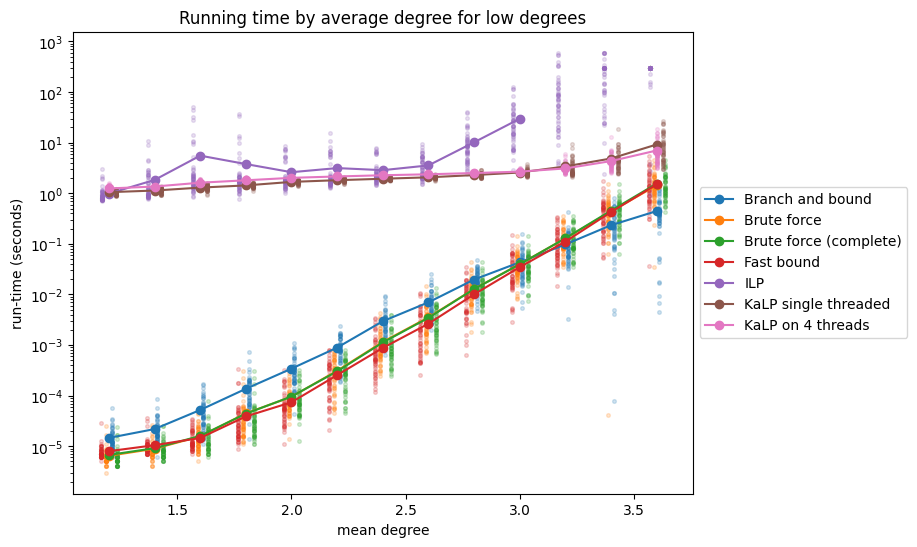

In [8]:
plt_with_scatter(
  benchmark, 
  offsets=list(np.linspace(-0.035,0.035,4)) + list(np.linspace(-0.03,0.03,3)),
  title="Running time by average degree for low degrees",
)

plt.yscale("log")
plt.gcf().set_size_inches(8, 6)
plt.savefig(os.path.join(benchmark.benchmark_path, "plot.png"), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(benchmark.benchmark_path, "plot.pdf"), dpi=400, bbox_inches='tight')

A plot with symmetric errorbars. 
These errorbars are a little meaningless because the distributions are very skewed, and because we prefer logarithmic axes.

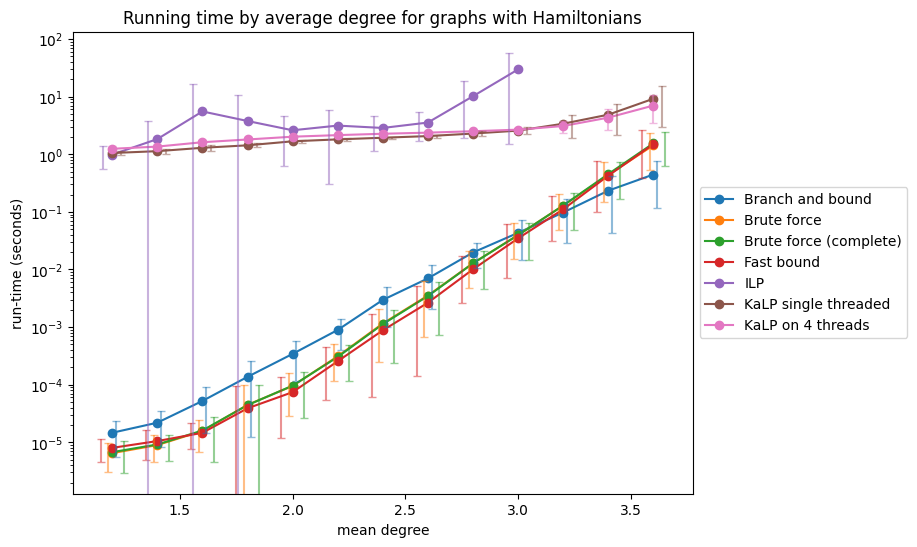

In [70]:
plot_with_symmetric_errbars(
  benchmark, 
  title="Running time by average degree for graphs with Hamiltonians",
  offsets=list(np.linspace(-0.05,0.05,4)) + list(np.linspace(-0.04,0.04,3))
)

plt.yscale("log")

plt.gcf().set_size_inches(8, 6)

A boxplot of one of the methods

run_time    Axes(0.125,0.11;0.775x0.77)
dtype: object

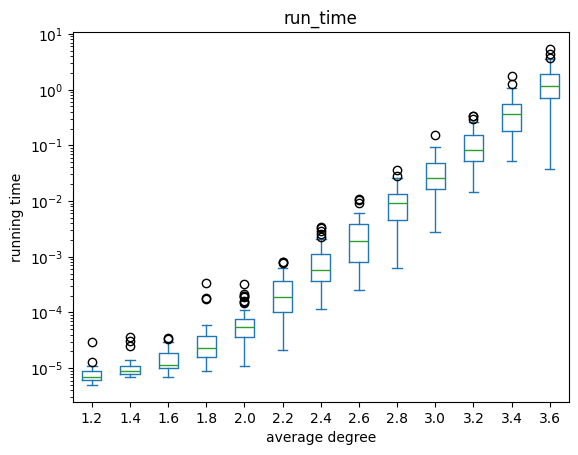

In [71]:
df[df["solver"] == 0][["run_time", "average_out_degree"]].plot.box(
  by="average_out_degree", 
  logy=True,
  xlabel="average degree",
  ylabel="running time"
)